# Курсовой проект для курса "Python для Data Science"
## Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

## Целевая переменная:
Price

## Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook  с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

## Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

## Примечания:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая.
В файлах не должны содержаться индексы из датафрейма.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

# Импорт данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline
pd.options.display.max_columns = 100

In [2]:
data = pd.read_csv('train.csv')
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


# One Hot Encoding

Смотрим количество уникальных значений, чтобы мы не разорвались по памяти

In [4]:
print('Ecology_2 unique:', data['Ecology_2'].unique())
print('Ecology_3 unique:', data['Ecology_3'].unique())
print('Shops_2 unique:', data['Shops_2'].unique())

Ecology_2 unique: ['B' 'A']
Ecology_3 unique: ['B' 'A']
Shops_2 unique: ['B' 'A']


In [5]:
def one_hot_encoder(adata):
    adata = pd.get_dummies(adata, columns=['Ecology_2', 'Ecology_3', 'Shops_2'])
    adata.drop(columns=['Ecology_2_A', 'Ecology_3_A', 'Shops_2_A'], inplace=True)
    adata.rename(columns={'Ecology_2_B': 'Ecology_2', 'Ecology_3_B': 'Ecology_3', 'Shops_2_B': 'Shops_2'}, inplace=True)
    return adata


data = one_hot_encoder(data.copy())
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2,Ecology_3,Shops_2
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,1,1,1


# Модели

Обучим на идеальном подмножестве выборки данных модели, которые исправят выбросы в данных

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


def model_fit(x_train, x_test, y_train, y_test):
    clf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                       param_grid=[{'n_estimators': [100], 'max_depth': [3, 5, 9, 15, 27]}],
                       cv=5)
    clf.fit(x_train, y_train)
    print('r2:', r2_score(y_test, clf.predict(x_test)))
    return clf


def show_model(clf_model):
    print('Лучшие параметры модели:', clf_model.best_params_)
    for mean, std, params in zip(clf_model.cv_results_['mean_test_score'], clf_model.cv_results_['std_test_score'], clf_model.cv_results_['params']):
        print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

# Подготавливаем неправильно вбитые данные
## Swap bigger 'LifeSquare' with 'Square'

In [7]:
def swap_lifesquare_with_square(adata):
    tmp_filter_col = lambda df: (df['LifeSquare'].notna()) & (df['LifeSquare'] > df['Square'])
    adata['tmp_filter_col'] = tmp_filter_col(adata)
    print('Before LifeSquare⇔Square swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.loc[adata['tmp_filter_col'], 'LifeSquare'], adata.loc[adata['tmp_filter_col'], 'Square'] = adata.loc[adata['tmp_filter_col'], 'Square'], adata.loc[adata['tmp_filter_col'], 'LifeSquare']
    print('After LifeSquare⇔Square swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.drop(columns=['tmp_filter_col'], inplace=True)
    return adata
data = swap_lifesquare_with_square(data.copy())

Before LifeSquare⇔Square swap:  482
After LifeSquare⇔Square swap:  0


## Swap bigger 'Floor' with 'HouseFloor'

In [8]:
def swap_floor_with_housefloor(adata):
    tmp_filter_col = lambda df: (df['HouseFloor'] > 0) & (df['Floor'] > df['HouseFloor'])
    adata['tmp_filter_col'] = tmp_filter_col(adata)
    print('Before Floor⇔HouseFloor swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.loc[adata['tmp_filter_col'], 'Floor'], adata.loc[adata['tmp_filter_col'], 'HouseFloor'] = adata.loc[adata['tmp_filter_col'], 'HouseFloor'], adata.loc[adata['tmp_filter_col'], 'Floor']
    print('After Floor⇔HouseFloor swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.drop(columns=['tmp_filter_col'], inplace=True)
    return adata
data = swap_floor_with_housefloor(data.copy())

Before Floor⇔HouseFloor swap:  1556
After Floor⇔HouseFloor swap:  0


In [9]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2,Ecology_3,Shops_2
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,57.223484,36.048753,6.273300,7.943200,13.192900,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,4859.01902,43.587592,0.839512,77.309420,19.372398,28.560917,5.228127,6.372139,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.00000,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.866858,22.765174,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.633651,32.760108,6.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,12592.50000,75.000000,2.000000,66.004634,45.029599,9.000000,11.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,16798.00000,209.000000,19.000000,7480.592129,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


# Выбросы HouseYear

In [10]:
def fix_houseyear(adata, hy_median):
    invalid_hy_filter = lambda df: ((df['HouseYear'] < 1900) | (df['HouseYear'] > 2030))
    adata.loc[lambda df: invalid_hy_filter(df), 'HouseYear'] = hy_median
    return adata

In [11]:
hy_median = data['HouseYear'].median()
data = fix_houseyear(data.copy(), hy_median)
data.loc[:, ['HouseYear']].describe()

,HouseYear
count,10000.000000
mean,1984.863800
std,18.409979
min,1910.000000
25%,1974.000000
50%,1977.000000
75%,2001.000000
max,2020.000000


# Выбросы HouseFloor

In [12]:
def fix_housefloor(adata, hf_basedon_year, hf_median):
    invalid_hf_filter = lambda df: ((df['HouseFloor'] < 1) | (df['HouseFloor'] > 50))
    fixed_hf = adata.loc[lambda df: invalid_hf_filter(df), 'HouseYear'].map(lambda yr: hf_basedon_year.get(yr, default=hf_median))
    adata.loc[lambda df: invalid_hf_filter(df), 'HouseFloor'] = fixed_hf
    return adata

In [13]:
hf_basedon_year = data.groupby('HouseYear')['HouseFloor'].median()
hf_median = data['HouseYear'].median()
data = fix_housefloor(data.copy(), hf_basedon_year,  hf_median)
data.loc[:, ['HouseFloor']].describe()

,HouseFloor
count,10000.000000
mean,13.623800
std,5.794811
min,1.000000
25%,9.000000
50%,14.000000
75%,17.000000
max,48.000000


# Отсутствующие значения Healthcare_1

In [14]:
healthcare_corr = data.loc[lambda df: df['Healthcare_1'].notnull(), :].corr().loc[lambda df: (np.abs(df['Healthcare_1']) > 0.1) & (np.abs(df['Healthcare_1']) < 1), ['Healthcare_1']]
healthcare_corr

,Healthcare_1
DistrictId,0.304335
Floor,-0.112202
HouseFloor,-0.191400
HouseYear,-0.205125
Social_3,0.133877
Helthcare_2,0.203177
Price,0.138755
Ecology_3,-0.114715


In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    data.loc[lambda df: df['Healthcare_1'].notnull(), ['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_3', 'Helthcare_2', 'Ecology_3']],
    data.loc[lambda df: df['Healthcare_1'].notnull(), 'Healthcare_1'],
    test_size=0.25,
    random_state=42
)
clf_healthcare = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_healthcare)

r2: 0.9858626888672526
Лучшие параметры модели: {'max_depth': 27, 'n_estimators': 100}
0.3687 (±0.0399) for {'max_depth': 3, 'n_estimators': 100}
0.6467 (±0.0514) for {'max_depth': 5, 'n_estimators': 100}
0.9303 (±0.0332) for {'max_depth': 9, 'n_estimators': 100}
0.9689 (±0.0225) for {'max_depth': 15, 'n_estimators': 100}
0.9692 (±0.0224) for {'max_depth': 27, 'n_estimators': 100}


In [16]:
def fix_healthcare1(adata, model):
    hc1_filter = lambda df: df['Healthcare_1'].isnull()
    features = adata.loc[lambda df: hc1_filter(df), ['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_3', 'Helthcare_2', 'Ecology_3']]
    adata.loc[lambda df: hc1_filter(df), 'Healthcare_1'] = model.predict(features)
    return adata


data = fix_healthcare1(data.copy(), clf_healthcare)

# Выбросы Rooms

In [17]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Отфильтровано: 17 из 10000


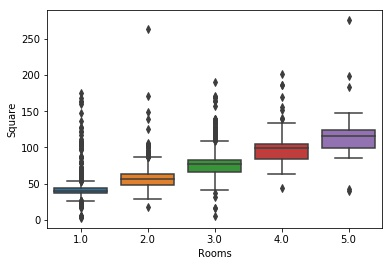

In [18]:
rooms_filter = lambda df: (df['Rooms'] >= 1) & (df['Rooms'] <= 5) & (df['Square'] <= 400)
print('Отфильтровано:', len(data.loc[lambda df: ~rooms_filter(df), 'Rooms']), 'из', len(data['Rooms']))
sns.boxplot(data.loc[lambda df: rooms_filter(df), 'Rooms'], data.loc[lambda df: rooms_filter(df), 'Square'])

In [19]:
square_quantiles = data.loc[lambda df: rooms_filter(df), :].groupby('Rooms')[['Square']].quantile(q=[0.25, 0.5, 0.75], interpolation='nearest')
square_quantiles

Square
Rooms                 
1.0   0.25   36.730798
      0.50   40.504282
      0.75   43.656886
2.0   0.25   47.885352
      0.50   55.896394
      0.75   63.456181
3.0   0.25   66.033045
      0.50   77.466387
      0.75   83.268318
4.0   0.25   83.833387
      0.50   98.686703
      0.75  104.769022
5.0   0.25   95.617533
      0.50  114.313752
      0.75  124.933289

In [20]:
def fix_rooms(adata):
    adata.loc[lambda df: df['Square'] < 45, 'Rooms'] = 1.0
    adata.loc[lambda df: (df['Square'] >= 45) & (df['Square'] < 65), 'Rooms'] = 2.0
    adata.loc[lambda df: (df['Square'] >= 65) & (df['Square'] < 85), 'Rooms'] = 3.0
    adata.loc[lambda df: (df['Square'] >= 85) & (df['Square'] < 100), 'Rooms'] = 4.0
    adata.loc[lambda df: df['Square'] > 100, 'Rooms'] = 5.0
    return adata


data = fix_rooms(data.copy())
data.corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))[['Rooms']].dropna().sort_values('Rooms', ascending=False)

,Rooms
LifeSquare,0.685835
Price,0.564593
Square,0.268729
HouseYear,0.155315
HouseFloor,0.120555


# Выбросы Square

In [21]:
square_filter = lambda df: (df['Square'] > 10) & (df['Square'] < 220)
print('Отфильтровано:', len(data.loc[lambda df: ~square_filter(df), 'Square']), 'из', len(data['Square']))
data.loc[lambda df: square_filter(df), :].corr().where(lambda df: (df > 0.1) & (df < 1))[['Square']].dropna().sort_values('Square', ascending=False)

Отфильтровано: 16 из 10000


,Square
Rooms,0.938541
LifeSquare,0.774811
Price,0.581521
HouseYear,0.192798
HouseFloor,0.152357


In [22]:
x_train, x_test, y_train, y_test = train_test_split(
    data.loc[lambda df: square_filter(df), ['Rooms', 'HouseFloor', 'HouseYear', 'Floor', 'DistrictId']],
    data.loc[lambda df: square_filter(df), 'Square'],
    test_size=0.25,
    random_state=42
)
clf_square = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_square)

r2: 0.9065932153750342
Лучшие параметры модели: {'max_depth': 9, 'n_estimators': 100}
0.9009 (±0.0226) for {'max_depth': 3, 'n_estimators': 100}
0.9024 (±0.0274) for {'max_depth': 5, 'n_estimators': 100}
0.9051 (±0.0275) for {'max_depth': 9, 'n_estimators': 100}
0.8990 (±0.0288) for {'max_depth': 15, 'n_estimators': 100}
0.8952 (±0.0281) for {'max_depth': 27, 'n_estimators': 100}


In [23]:
def fix_square(adata, model):
    features = adata.loc[lambda df: ~square_filter(df), ['Rooms', 'HouseFloor', 'HouseYear', 'Floor', 'DistrictId']]
    adata.loc[lambda df: ~square_filter(df), 'Square'] = model.predict(features)
    return adata


#data = fix_square(data.copy(), clf_square)
data.corr().where(lambda df: (df > 0.1) & (df < 1))[['Square']].dropna().sort_values('Square', ascending=False)

,Square
Rooms,0.268729
LifeSquare,0.219987
Price,0.142499


# Отсутствующие значения LifeSquare

In [24]:
lifesquare_filter = lambda df: (
    (df['LifeSquare'].notna()) & 
    (df['LifeSquare'] > 20) & 
    (df['LifeSquare'] < 220) & 
    (df['LifeSquare'] < df['Square'] * 0.9) &
    (df['LifeSquare'] > df['Square'] * 0.3)
)
print('Отфильтровано:', len(data.loc[lambda df: ~lifesquare_filter(df), 'LifeSquare']), 'из', len(data['LifeSquare']))
data.loc[lambda df: lifesquare_filter(df), :].corr().where(lambda df: (df > 0.1) & (df < 1))[['LifeSquare']].dropna().sort_values('LifeSquare', ascending=False)

Отфильтровано: 4206 из 10000


,LifeSquare
Square,0.921491
Rooms,0.883294
Price,0.607248
KitchenSquare,0.273953
HouseFloor,0.119561
HouseYear,0.115844


In [25]:
x_train, x_test, y_train, y_test = train_test_split(
    data.loc[lambda df: lifesquare_filter(df), ['Square', 'Rooms', 'HouseYear', 'HouseFloor']],
    data.loc[lambda df: lifesquare_filter(df), 'LifeSquare'],
    test_size=0.25,
    random_state=42
)
clf_lifesquare = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_lifesquare)

r2: 0.8859635129645752
Лучшие параметры модели: {'max_depth': 9, 'n_estimators': 100}
0.8476 (±0.0125) for {'max_depth': 3, 'n_estimators': 100}
0.8832 (±0.0217) for {'max_depth': 5, 'n_estimators': 100}
0.8854 (±0.0277) for {'max_depth': 9, 'n_estimators': 100}
0.8804 (±0.0253) for {'max_depth': 15, 'n_estimators': 100}
0.8784 (±0.0258) for {'max_depth': 27, 'n_estimators': 100}


In [26]:
def fix_lifesquare(adata, model):
    features = adata.loc[lambda df: ~lifesquare_filter(df), ['Square', 'Rooms', 'HouseYear', 'HouseFloor']]
    adata.loc[lambda df: ~lifesquare_filter(df), 'LifeSquare'] = model.predict(features)
    return adata


data = fix_lifesquare(data.copy(), clf_lifesquare)
data.corr().where(lambda df: (df > 0.1) & (df < 1))[['LifeSquare']].dropna().sort_values('LifeSquare', ascending=False)

,LifeSquare
Rooms,0.905746
Price,0.567482
Square,0.298873


# Выбросы KitchenSquare

Отфильтровано: 3307 из 10000


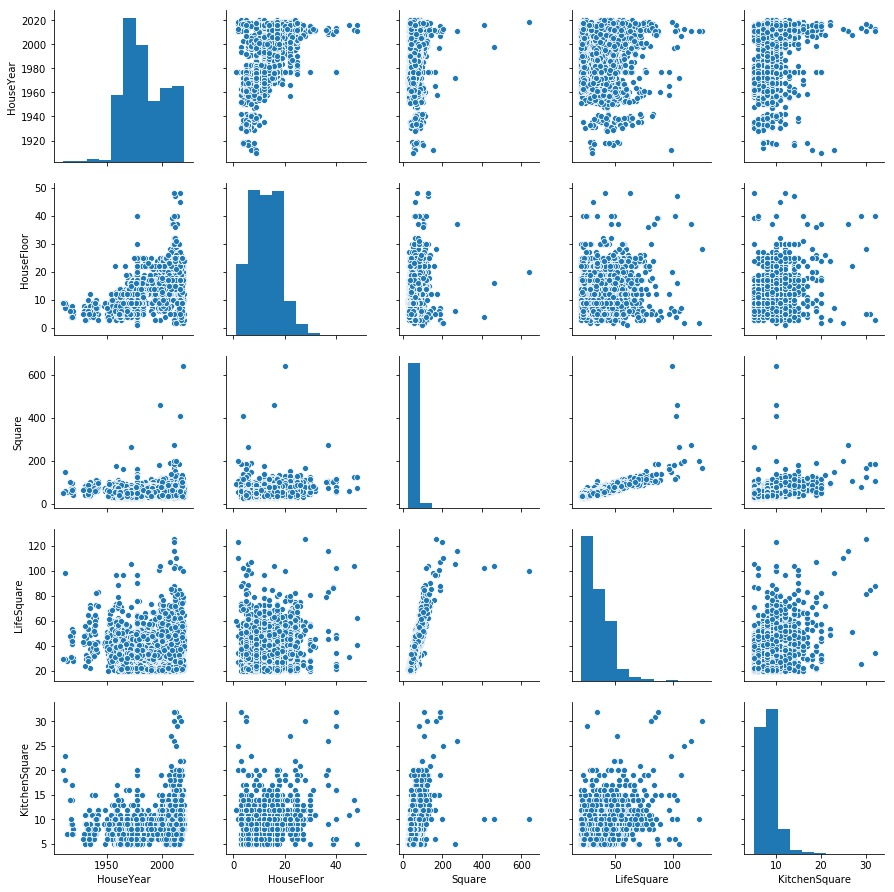

In [27]:
ks_filter = lambda df: (df['KitchenSquare'] >= 5) & (df['KitchenSquare'] <= 40) & (df['KitchenSquare'] < df['Square'] - df['LifeSquare'])
print('Отфильтровано:', len(data.loc[lambda df: ~ks_filter(df), 'KitchenSquare']), 'из', len(data['KitchenSquare']))
sns.pairplot(data.loc[lambda df: ks_filter(df), ['HouseYear', 'HouseFloor', 'Square', 'LifeSquare', 'KitchenSquare']])

In [28]:
data.loc[lambda df: ks_filter(df), :].corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))[['KitchenSquare']].dropna().sort_values('KitchenSquare', ascending=False)

,KitchenSquare
HouseYear,0.563720
HouseFloor,0.546331
Square,0.484231
Rooms,0.460239
LifeSquare,0.346422
Floor,0.311352
Price,0.300332
Healthcare_1,-0.103053
Social_1,-0.124260


In [29]:
x_train, x_test, y_train, y_test = train_test_split(
    data.loc[lambda df: ks_filter(df), ['HouseYear', 'HouseFloor', 'Square', 'Rooms', 'LifeSquare', 'Floor', 'DistrictId', 'Healthcare_1', 'Helthcare_2', 'Social_1']],
    data.loc[lambda df: ks_filter(df), 'KitchenSquare'],
    test_size=0.25,
    random_state=42
)
clf_kitchen = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_kitchen)

r2: 0.7124267553567599
Лучшие параметры модели: {'max_depth': 15, 'n_estimators': 100}
0.5223 (±0.0232) for {'max_depth': 3, 'n_estimators': 100}
0.6243 (±0.0318) for {'max_depth': 5, 'n_estimators': 100}
0.6751 (±0.0191) for {'max_depth': 9, 'n_estimators': 100}
0.6771 (±0.0250) for {'max_depth': 15, 'n_estimators': 100}
0.6767 (±0.0228) for {'max_depth': 27, 'n_estimators': 100}


In [30]:
def fix_kitchensquare(adata, model):
    features = adata.loc[lambda df: ~ks_filter(df), ['HouseYear', 'HouseFloor', 'Square', 'Rooms', 'LifeSquare', 'Floor', 'DistrictId', 'Healthcare_1', 'Helthcare_2', 'Social_1']]
    adata.loc[lambda df: ~ks_filter(df), 'KitchenSquare'] = model.predict(features)
    return adata


data = fix_kitchensquare(data.copy(), clf_kitchen)
data.corr().where(lambda df: (df > 0.1) & (df < 1))[['KitchenSquare']].dropna().sort_values('KitchenSquare', ascending=False)

,KitchenSquare
Rooms,0.494374
HouseYear,0.477099
HouseFloor,0.459895
LifeSquare,0.403746
Floor,0.226381
Price,0.192873
Square,0.165980


# Производные DistrictId

In [31]:
def add_district_medians(adata, district_columns):
    for col in district_columns:
        new_col = 'DistrictMedian' + col
        col_median = adata[col].median()
        grouped = adata.groupby('DistrictId', as_index=False)[[col]].median().rename(columns={col: new_col})
        adata = adata.merge(grouped, how='left', on='DistrictId')
        adata[[new_col]] = adata[[new_col]].fillna(col_median)
    return adata

In [32]:
district_columns = ['HouseYear', 'HouseFloor', 'Square', 'Rooms', 'Social_1', 'Healthcare_1', 'Shops_1']

In [33]:
data = add_district_medians(data.copy(), district_columns)

# Шум

In [34]:
def add_noise(adata):
    np.random.seed(42)
    adata['Price'] = adata['Price'] + 2500 * np.random.randn(adata.shape[0]) * (adata['Rooms'] + 1)
    return adata

# Корелляция

In [35]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2,Ecology_3,Shops_2,DistrictMedianHouseYear,DistrictMedianHouseFloor,DistrictMedianSquare,DistrictMedianRooms,DistrictMedianSocial_1,DistrictMedianHealthcare_1,DistrictMedianShops_1
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,2.012300,57.223484,34.180386,8.683720,7.943200,13.623800,1984.863800,0.118858,24.687000,5352.157400,8.039200,1011.453416,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,1978.260200,13.801400,53.391337,1.975700,24.187900,983.127982,4.021100
std,4859.01902,43.587592,0.976957,77.309420,12.040044,2.450471,5.228127,5.794811,18.409979,0.119025,17.532614,4006.799803,23.831875,861.429732,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,9.270671,3.364177,6.185765,0.242003,17.126074,811.036286,4.732208
min,0.00000,0.000000,1.000000,2.377248,20.001861,5.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,1924.500000,5.000000,33.533077,1.000000,1.000000,30.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.866858,23.206856,7.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,283.400000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,1975.000000,12.000000,47.651571,2.000000,5.000000,523.260000,0.000000
50%,8394.50000,36.000000,2.000000,52.633651,32.418460,9.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,845.230000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,1977.000000,14.000000,54.345128,2.000000,25.000000,791.160000,3.000000
75%,12592.50000,75.000000,3.000000,66.004634,41.849263,10.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1340.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,1980.000000,17.000000,56.876553,2.000000,35.000000,1230.620000,5.000000
max,16798.00000,209.000000,5.000000,7480.592129,125.486563,32.000000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,2011.000000,18.500000,85.591121,3.500000,74.000000,4849.000000,23.000000


In [36]:
perceptible_corr = data.drop(columns='Id').corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))
perceptible_corr

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2,Ecology_3,Shops_2,DistrictMedianHouseYear,DistrictMedianHouseFloor,DistrictMedianSquare,DistrictMedianRooms,DistrictMedianSocial_1,DistrictMedianHealthcare_1,DistrictMedianShops_1
DistrictId,NaN,NaN,NaN,NaN,-0.218201,NaN,-0.219881,-0.201194,NaN,0.246463,0.167479,0.136095,0.325802,0.306147,0.174214,0.265100,NaN,NaN,NaN,-0.186508,-0.456425,-0.216901,NaN,0.249887,0.398192,0.164952
Rooms,NaN,NaN,0.268729,0.905746,0.494374,NaN,0.120555,0.155315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.564593,NaN,NaN,NaN,NaN,0.110121,0.219745,0.148894,NaN,NaN,NaN
Square,NaN,0.268729,NaN,0.298873,0.165980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LifeSquare,NaN,0.905746,0.298873,NaN,0.403746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.567482,NaN,NaN,NaN,NaN,NaN,0.183482,0.129996,NaN,NaN,NaN
KitchenSquare,-0.218201,0.494374,0.165980,0.403746,NaN,0.226381,0.459895,0.477099,-0.125938,-0.308615,-0.236810,NaN,-0.162647,-0.210558,NaN,0.192873,NaN,NaN,-0.115502,0.184395,0.441733,0.380615,0.146059,-0.302947,-0.201271,NaN
Floor,NaN,NaN,NaN,NaN,0.226381,NaN,0.598678,0.258989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113605,NaN,NaN,NaN,0.141652,0.196105,0.149852,NaN,NaN,NaN,NaN
HouseFloor,-0.219881,0.120555,NaN,NaN,0.459895,0.598678,NaN,0.461408,NaN,-0.106483,NaN,NaN,-0.159567,-0.140463,NaN,0.107305,NaN,NaN,NaN,0.250134,0.393980,0.270315,NaN,-0.120861,-0.188552,NaN
HouseYear,-0.201194,0.155315,NaN,NaN,0.477099,0.258989,0.461408,NaN,NaN,NaN,NaN,NaN,-0.193124,-0.116430,NaN,NaN,NaN,NaN,NaN,0.370396,0.388437,0.205505,NaN,NaN,-0.197282,NaN
Ecology_1,NaN,NaN,NaN,NaN,-0.125938,NaN,NaN,NaN,NaN,NaN,NaN,-0.124068,NaN,NaN,NaN,NaN,-0.110725,-0.223197,NaN,NaN,-0.142711,-0.197843,-0.118502,NaN,NaN,NaN
Social_1,0.246463,NaN,NaN,NaN,-0.308615,NaN,-0.106483,NaN,NaN,NaN,0.955988,NaN,0.158859,0.524593,0.526272,0.263286,NaN,NaN,0.144644,0.251599,-0.369877,-0.308965,NaN,0.891004,0.225137,0.472020


Колонки, кореллирующие с ценой

In [37]:
price_corr_columns = perceptible_corr[['Price']].dropna().sort_values('Price', ascending=False)
print(price_corr_columns.index.values)
price_corr_columns

['LifeSquare' 'Rooms' 'DistrictMedianSocial_1' 'DistrictId' 'Social_1'
 'Helthcare_2' 'Social_2' 'KitchenSquare' 'DistrictMedianShops_1'
 'Healthcare_1' 'Shops_1' 'DistrictMedianHealthcare_1' 'Square'
 'DistrictMedianRooms' 'Floor' 'HouseFloor' 'DistrictMedianHouseFloor']


,Price
LifeSquare,0.567482
Rooms,0.564593
DistrictMedianSocial_1,0.275723
DistrictId,0.265100
Social_1,0.263286
Helthcare_2,0.253090
Social_2,0.239226
KitchenSquare,0.192873
DistrictMedianShops_1,0.189541
Healthcare_1,0.181614


# Собираем итоговый датафрейм

In [38]:
def preprocessData(df, houseyear_median, housefloor_basedon_year, housefloor_median, healthcare_model, square_model, lifesquare_model, kitchensquare_model):
    df = one_hot_encoder(df)  # 'Ecology_2', 'Ecology_3', 'Shops_2'
    df = swap_lifesquare_with_square(df.copy())  # подготавливаем 'LifeSquare', 'Square'
    df = swap_floor_with_housefloor(df.copy())  # подготавливаем 'Floor', 'HouseFloor'
    df = fix_houseyear(df.copy(), houseyear_median)  # исправляем HouseYear
    df = fix_housefloor(df.copy(), housefloor_basedon_year, housefloor_median)  # исправляем HouseFloor
    df = fix_healthcare1(df.copy(), healthcare_model)  # исправляем Healthcare_1
    df = fix_rooms(df.copy())  # исправляем Rooms
    #df = fix_square(df.copy(), square_model)  # исправляем Square
    df = fix_lifesquare(df.copy(), lifesquare_model)  # заполняем пустые значения LifeSquare
    df = fix_kitchensquare(df.copy(), kitchensquare_model)  # исправляем KitchenSquare
    df = add_district_medians(df.copy(), district_columns)  # средние показатели района: его "молодость", "высотность", "социальный статус" и др.
    #df = add_noise(df.copy())  # добавляем шум, чтобы избежать от переобучения
    return df

data_final = preprocessData(pd.read_csv('train.csv'), hy_median, hf_basedon_year, hf_median, clf_healthcare, clf_square, clf_lifesquare, clf_kitchen)

Before LifeSquare⇔Square swap:  482
After LifeSquare⇔Square swap:  0
Before Floor⇔HouseFloor swap:  1556
After Floor⇔HouseFloor swap:  0


# Масштабируем признаки

In [39]:
from sklearn.preprocessing import StandardScaler
train_columns = data_final.columns.copy().drop(['Id', 'Price', 'LifeSquare', 'Ecology_2', 'Rooms', 'Social_1'])
print('total features:', len(train_columns))
df_train = data_final.loc[:, train_columns]
df_test = data_final.loc[:, data_final.columns == 'Price']

scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled = pd.DataFrame(df_train_scaled, columns=train_columns)
df_train_scaled.head(3)

total features: 21


,DistrictId,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_3,Shops_2,DistrictMedianHouseYear,DistrictMedianHouseFloor,DistrictMedianSquare,DistrictMedianRooms,DistrictMedianSocial_1,DistrictMedianHealthcare_1,DistrictMedianShops_1
0,-0.353348,-0.119551,-1.095240,-0.180418,-0.797961,-0.861739,-0.250529,0.654880,-0.127533,-0.653717,-0.883480,1.408356,0.16816,0.299864,-0.351686,-0.535492,-0.930195,0.100417,0.514569,-0.657313,1.474840
1,-0.215687,0.109438,-0.279030,-0.180418,-0.797961,-0.372849,-0.998053,1.237169,-0.295384,-0.895595,-0.213923,2.448700,0.16816,0.299864,0.295549,-0.535492,-0.881857,0.100417,0.689749,-0.124474,-0.849773
2,0.059635,-0.158792,-1.306106,0.010865,-0.280230,-0.916060,-0.581588,0.600720,-0.337347,-0.908365,-0.213923,-0.256195,0.16816,0.299864,0.511294,0.950830,0.152268,0.100417,0.572962,-0.929879,-0.215787


# Предсказание
## RandomForestRegressor с обучением на фолдах
Наблюдаем за изменением главной метрики

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


def fit_clf_model(x_train, x_test, y_train, y_test):
    clf = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42), 
        param_grid=[{'n_estimators': [50],  
                     'max_depth': [15],
                     'max_features': [6]}],
        cv=5
    )
    clf.fit(x_train, y_train)
    #  {'max_depth': [9, 15, 17, 19, 27], 'max_features': [9, 15, 21], 'n_estimators': 10} # best: 9, 10 | 18, 8 | 15, 6
    cell_index = clf.cv_results_['params'].index(clf.best_params_)
    mean = clf.cv_results_['mean_test_score'][cell_index]
    std = clf.cv_results_['std_test_score'][cell_index]
    print("mse: %0.4f (±%0.4f) for %r" % (mean, std * 2, clf.best_params_))
    print('r2_max:', 0.731215935135764)
    print('r2:', r2_score(y_test, clf.predict(x_test)))
    return clf


x_train, x_test, y_train, y_test = train_test_split(df_train_scaled, df_test, test_size=0.25, random_state=42)
fit_clf_model(x_train, x_test, y_train, y_test)

mse: 0.7362 (±0.0381) for {'max_depth': 15, 'max_features': 6, 'n_estimators': 50}
r2_max: 0.731215935135764
r2: 0.731215935135764


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [50], 'max_depth': [15], 'max_features': [6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## RandomForestRegressor final

In [41]:
final_model = fit_clf_model(df_train_scaled, df_train_scaled, df_test, df_test)

mse: 0.7384 (±0.0407) for {'max_depth': 15, 'max_features': 6, 'n_estimators': 50}
r2_max: 0.731215935135764
r2: 0.9280672729749161


In [42]:
pd.Series(final_model.best_estimator_.feature_importances_, index=train_columns).sort_values(ascending=False)

Square                        0.389075
Social_2                      0.065415
KitchenSquare                 0.061531
DistrictMedianSocial_1        0.059781
Social_3                      0.058574
DistrictMedianShops_1         0.043548
HouseYear                     0.043248
DistrictMedianSquare          0.042362
DistrictId                    0.033979
HouseFloor                    0.031647
Ecology_1                     0.027240
DistrictMedianHouseYear       0.025980
Healthcare_1                  0.025801
Floor                         0.023548
DistrictMedianHealthcare_1    0.019490
Shops_1                       0.019029
DistrictMedianHouseFloor      0.014539
Helthcare_2                   0.009742
DistrictMedianRooms           0.003801
Shops_2                       0.000954
Ecology_3                     0.000716
dtype: float64

# Экспорт предсказания

In [43]:
data_export = preprocessData(pd.read_csv('test.csv'), hy_median, hf_basedon_year, hf_median, clf_healthcare, clf_square, clf_lifesquare, clf_kitchen)
data_export_scaled = scaler.transform(data_export.drop(columns=['Id', 'LifeSquare', 'Ecology_2', 'Rooms', 'Social_1']))
data_export['Predict'] = final_model.predict(data_export_scaled)
data_export[['Id', 'Predict']].to_csv('AIatsuk_predictions.csv', index=False)

Before LifeSquare⇔Square swap:  241
After LifeSquare⇔Square swap:  0
Before Floor⇔HouseFloor swap:  753
After Floor⇔HouseFloor swap:  0
